https://www.kaggle.com/allunia/santander-customer-transaction-eda

In [124]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


# Kernel Settings

In [125]:
fit_gaussians = False
use_plotly = True

In [126]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
submission = pd.read_csv("../input/sample_submission.csv")

In [127]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [128]:
train.target.dtype

dtype('int64')

In [129]:
org_vars = train.drop(['target','ID_code'], axis = 1).columns.values
len(org_vars)

200

In [130]:
train['Id'] = train.index.values
orginal_trainid = train.ID_code.values

train.drop('ID_code', axis = 1, inplace = True)

In [131]:
train.isnull().sum().sum()

0

카운터나 정수 값은 없다. missing value도 없다

In [132]:
test["Id"] = test.index.values
original_testid = test.ID_code.values

test.drop("ID_code", axis=1, inplace=True)

In [133]:
submission.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


# What can we say about the target?

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

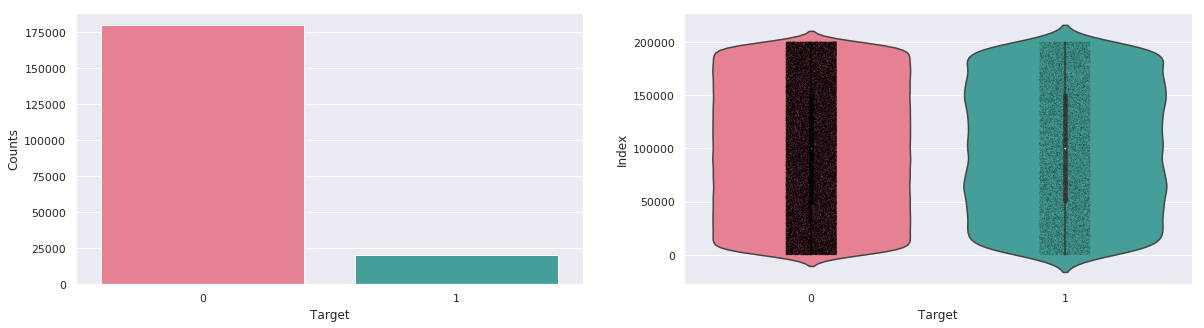

In [135]:
fig, ax = plt.subplots(1,2, figsize = (20,5))

sns.countplot(train.target.values, ax = ax[0], palette = 'husl')
sns.violinplot(x = train.target.values, y = train.index.values, ax = ax[1], palette='husl')
sns.stripplot(x = train.target.values, y = train.index.values, ax = ax[1], jitter = True, color = 'black', size = 0.5, alpha = 0.5)

ax[1].set_xlabel("Target")
ax[1].set_ylabel("Index");
ax[0].set_xlabel("Target")
ax[0].set_ylabel("Counts");

In [136]:
len(train[train.target ==1]) / len(train[train.target ==0])

0.1117163789174106

- imbalanced class problem을 해결해야 한다!
- index와 target간의 관계는 없어 보인다!
- jittering을 표현한 violinplot을 살펴보면, target값이 uniformly distributed한 걸 알 수 있다. 데이터의 순서를 맞출 때 굉장히 조심스럽게 처리한 것을 알 수 있다

# Can we find relationships between fetures?
## Linear Correlations

In [137]:
train_corr = train[org_vars].corr()

In [138]:
#변수간 correlation이 굉장히 작은 것을 알 수 있다
corr_series = pd.Series(index = org_vars)
for i, col in enumerate(org_vars) :
    corr_series[i] = train_corr[col].nlargest(2)[1]
corr_series.sort_values(ascending=False).head(10) #자기 자신을 제외하고 correlation가장 높은 경우

var_81     0.009714
var_165    0.009714
var_174    0.009490
var_189    0.009359
var_183    0.009359
var_169    0.009071
var_146    0.009071
var_132    0.008956
var_122    0.008956
var_172    0.008936
dtype: float64

In [139]:
train_corr = train.drop(['target'], axis = 1).corr()
train_corr = train_corr.values.flatten()
train_corr = train_corr[train_corr!=1]

test_corr = test.corr()
test_corr = test_corr.values.flatten()
test_corr = test_corr[test_corr!=1]

In [140]:
sns.set() #Set aesthetic parameters in one step.

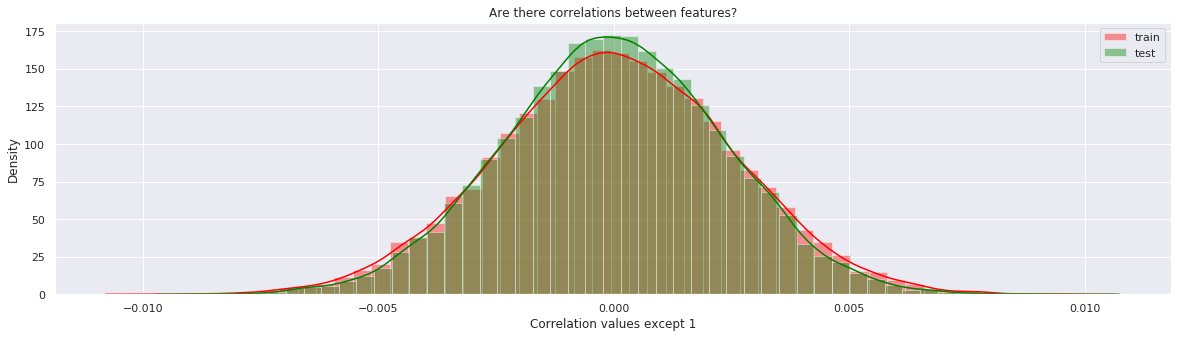

In [141]:
plt.figure(figsize = (20,5))
sns.distplot(train_corr, color = 'Red', label = 'train')
sns.distplot(test_corr, color = 'Green', label = 'test')

plt.xlabel('Correlation values except 1')
plt.ylabel('Density')
plt.title('Are there correlations between features?')
plt.legend()

Wow!! 모든 변수들이 train이든, test든 linear correlation이 없어보인다!!!! 정말 이상하네!! 아마도 어떤 변환에 의해 anonymized and decorrelated 된 게 아닌가 싶다

# RandomForest top Features
랜덤포레스트 모델의 중요 변수 Top10으로 시작해보자! 각각의 변수들이 선형성이 전혀 없으므로, nonlinear model을 사용하는 것이 좋겠다

In [142]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer

In [143]:
params = {'min_samples_leaf' : [20,25]}
rf = RandomForestClassifier(max_depth = 15, n_estimators = 15)
grid = GridSearchCV(rf, param_grid=params, cv = 3, n_jobs = -1, verbose = 2, scoring = make_scorer(roc_auc_score))

In [148]:
grid.fit(train.drop('target', axis = 1).values, train.target.values)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_samples_leaf': [20, 25]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=2)

In [149]:
#train data로 fitting해서 train으로 결과를 냈음에도 구리다
print('best score : ', grid.best_score_)
print('best parameters : ', grid.best_params_)

best score :  0.5001160575963444
best parameters :  {'min_samples_leaf': 20}


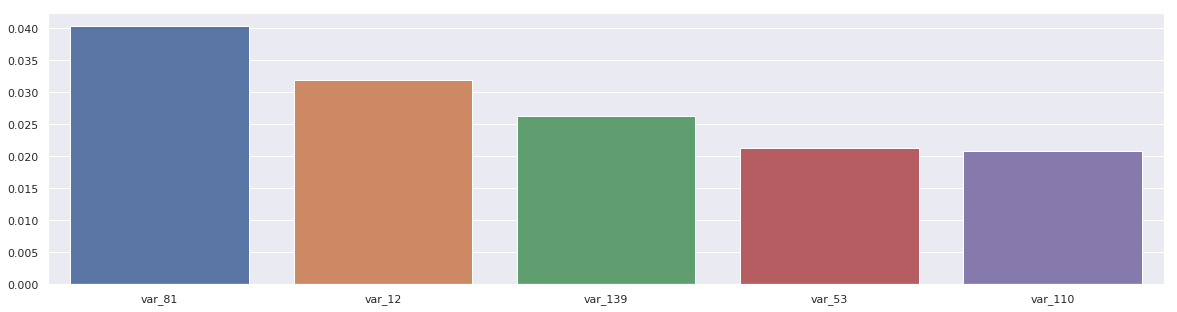

In [150]:
n_top = 5

importances = grid.best_estimator_.feature_importances_
idx = np.argsort(importances)[::-1][:n_top]
feature_names = train.drop('target', axis = 1).columns.values

plt.figure(figsize = (20,5))
sns.barplot(x = feature_names[idx], y = importances[idx])


## Exploring top features
target의 관점에서 주요변수들의 분포를 살펴보자! train과 test의 차이가 있나?

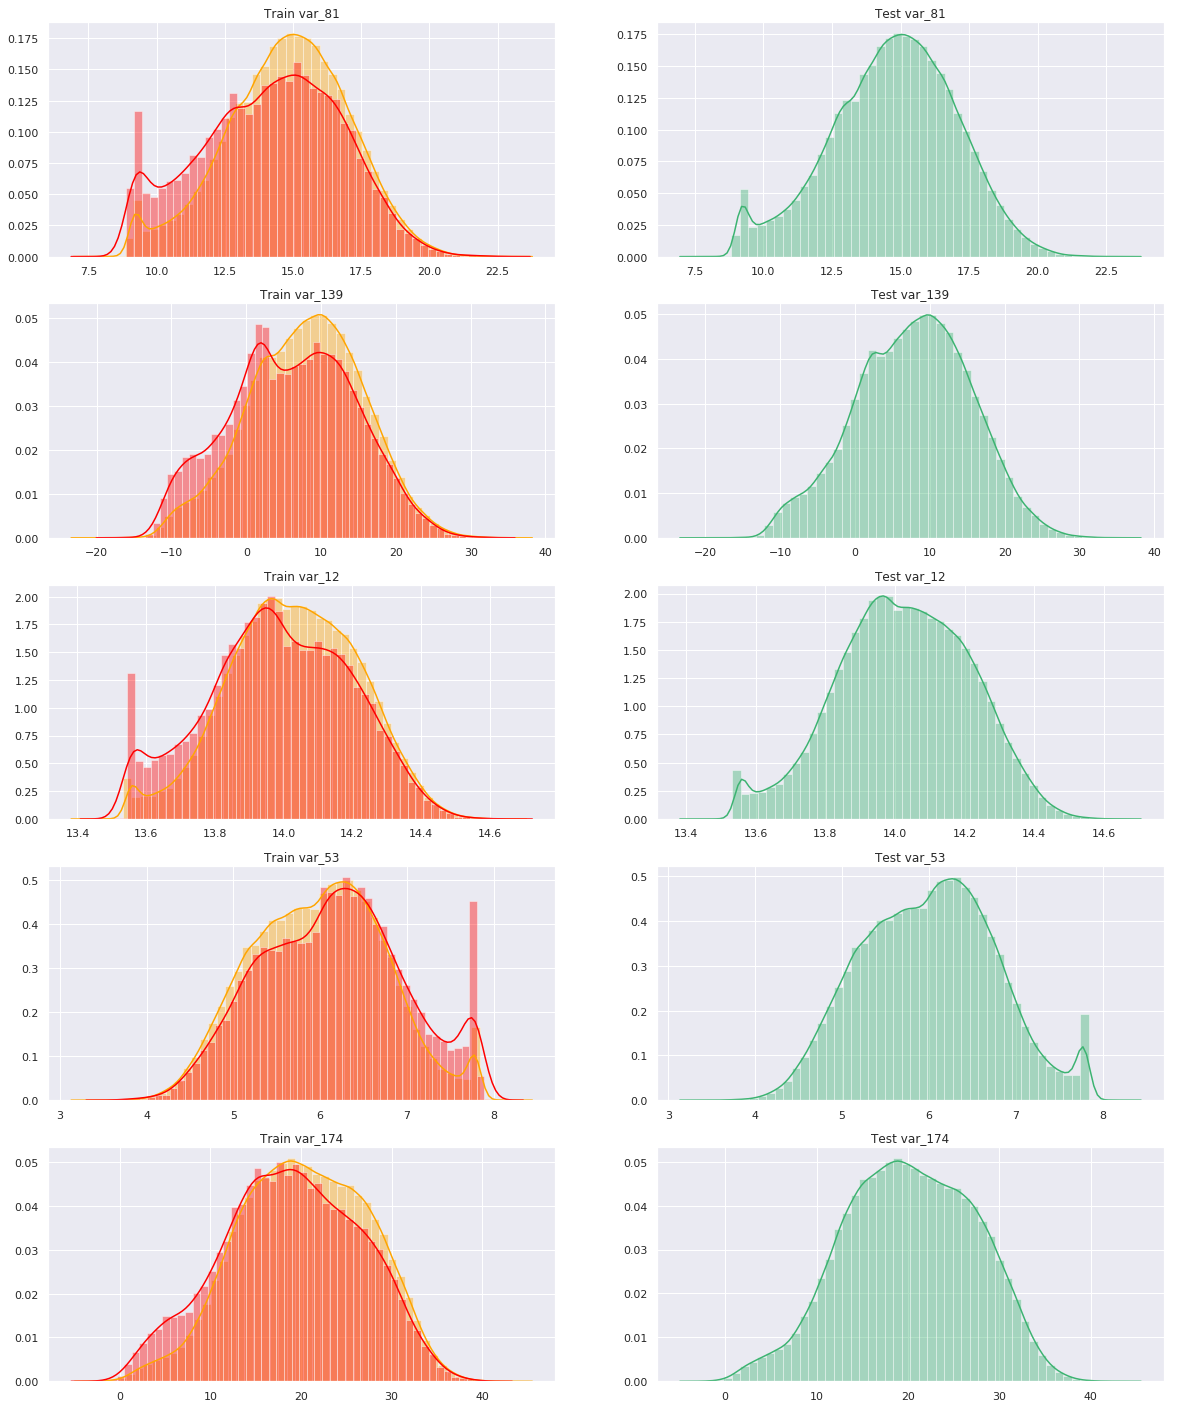

In [147]:
fig, ax = plt.subplots(n_top, 2, figsize = (20,5*n_top))

for n in range(n_top) :
    #train data
    sns.distplot(train.loc[train.target == 0, feature_names[idx][n]], ax = ax[n,0], color = 'Orange', norm_hist = True)
    sns.distplot(train.loc[train.target == 1, feature_names[idx][n]], ax = ax[n,0], color = 'Red', norm_hist = True)
    
    #test data
    sns.distplot(train.loc[:, feature_names[idx][n]], ax = ax[n,1], color = 'Mediumseagreen', norm_hist = True)
    
    ax[n,0].set_title('Train {}'.format(feature_names[idx][n]))
    ax[n,1].set_title('Test {}'.format(feature_names[idx][n]))
    ax[n,0].set_xlabel('')
    ax[n,1].set_xlabel('')

- var81,12,53은 특별한 peak점을 갖는 것을 알 수 있다. 왜 있을까?
- 그러한 peak point들이 test에서는 적은 것을 알 수 있다.

Text(0.5, 1.0, 'Test var_174')

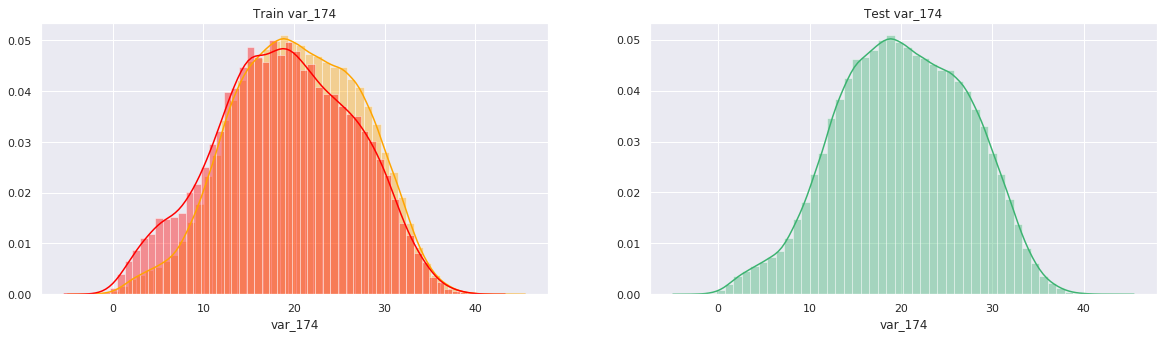

In [151]:
fig,ax = plt.subplots(1,2, figsize = (20,5))

sns.distplot(train.loc[train.target == 0, 'var_174'], ax = ax[0], color = 'Orange', norm_hist = True)
sns.distplot(train.loc[train.target == 1, 'var_174'], ax = ax[0], color = 'Red', norm_hist = True)

#test data
sns.distplot(train.loc[:, 'var_174'], ax = ax[1], color = 'Mediumseagreen', norm_hist = True)

ax[0].set_title('Train var_174')
ax[1].set_title('Test var_174')

- Variable 174 seem to miss the bulb on the right hand side of the distribution in the test data.

Text(0.5, 1.0, 'Test var_109')

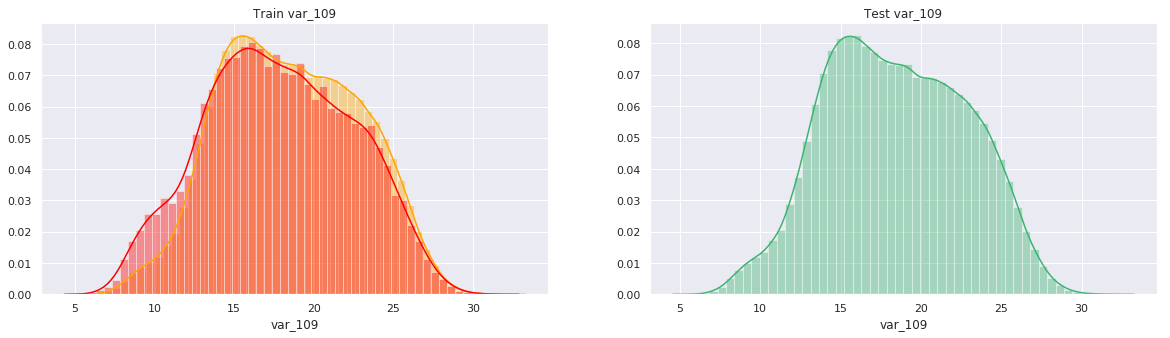

In [152]:
fig,ax = plt.subplots(1,2, figsize = (20,5))

sns.distplot(train.loc[train.target == 0, 'var_109'], ax = ax[0], color = 'Orange', norm_hist = True)
sns.distplot(train.loc[train.target == 1, 'var_109'], ax = ax[0], color = 'Red', norm_hist = True)

#test data
sns.distplot(train.loc[:, 'var_109'], ax = ax[1], color = 'Mediumseagreen', norm_hist = True)

ax[0].set_title('Train var_109')
ax[1].set_title('Test var_109')

Text(0.5, 1.0, 'Test var_110')

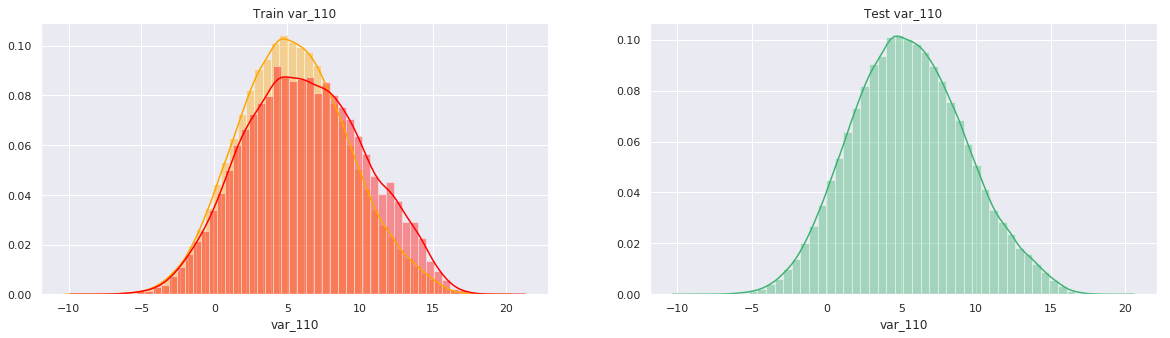

In [153]:
fig,ax = plt.subplots(1,2, figsize = (20,5))

sns.distplot(train.loc[train.target == 0, 'var_110'], ax = ax[0], color = 'Orange', norm_hist = True)
sns.distplot(train.loc[train.target == 1, 'var_110'], ax = ax[0], color = 'Red', norm_hist = True)

#test data
sns.distplot(train.loc[:, 'var_110'], ax = ax[1], color = 'Mediumseagreen', norm_hist = True)

ax[0].set_title('Train var_110')
ax[1].set_title('Test var_110')

In [156]:
#public kernel에 등장한 중요변수 두개도 추가
top = train.loc[:,list(feature_names[idx]) + ['var_109']]
top.describe()

,var_81,var_12,var_139,var_53,var_110,var_109
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,14.719024,14.023978,7.760193,6.008569,5.513238,18.458001
std,2.299567,0.190059,7.686433,0.764753,3.823253,4.355031
min,7.586500,13.434600,-21.274300,3.344900,-9.239800,5.769700
25%,13.214775,13.894000,2.387575,5.435600,2.817475,15.107175
50%,14.844500,14.025500,8.066250,6.027800,5.394300,18.281350
75%,16.340800,14.164200,13.232525,6.542900,8.104325,21.852900
max,23.132400,14.654500,36.097100,8.231500,19.519300,32.059100


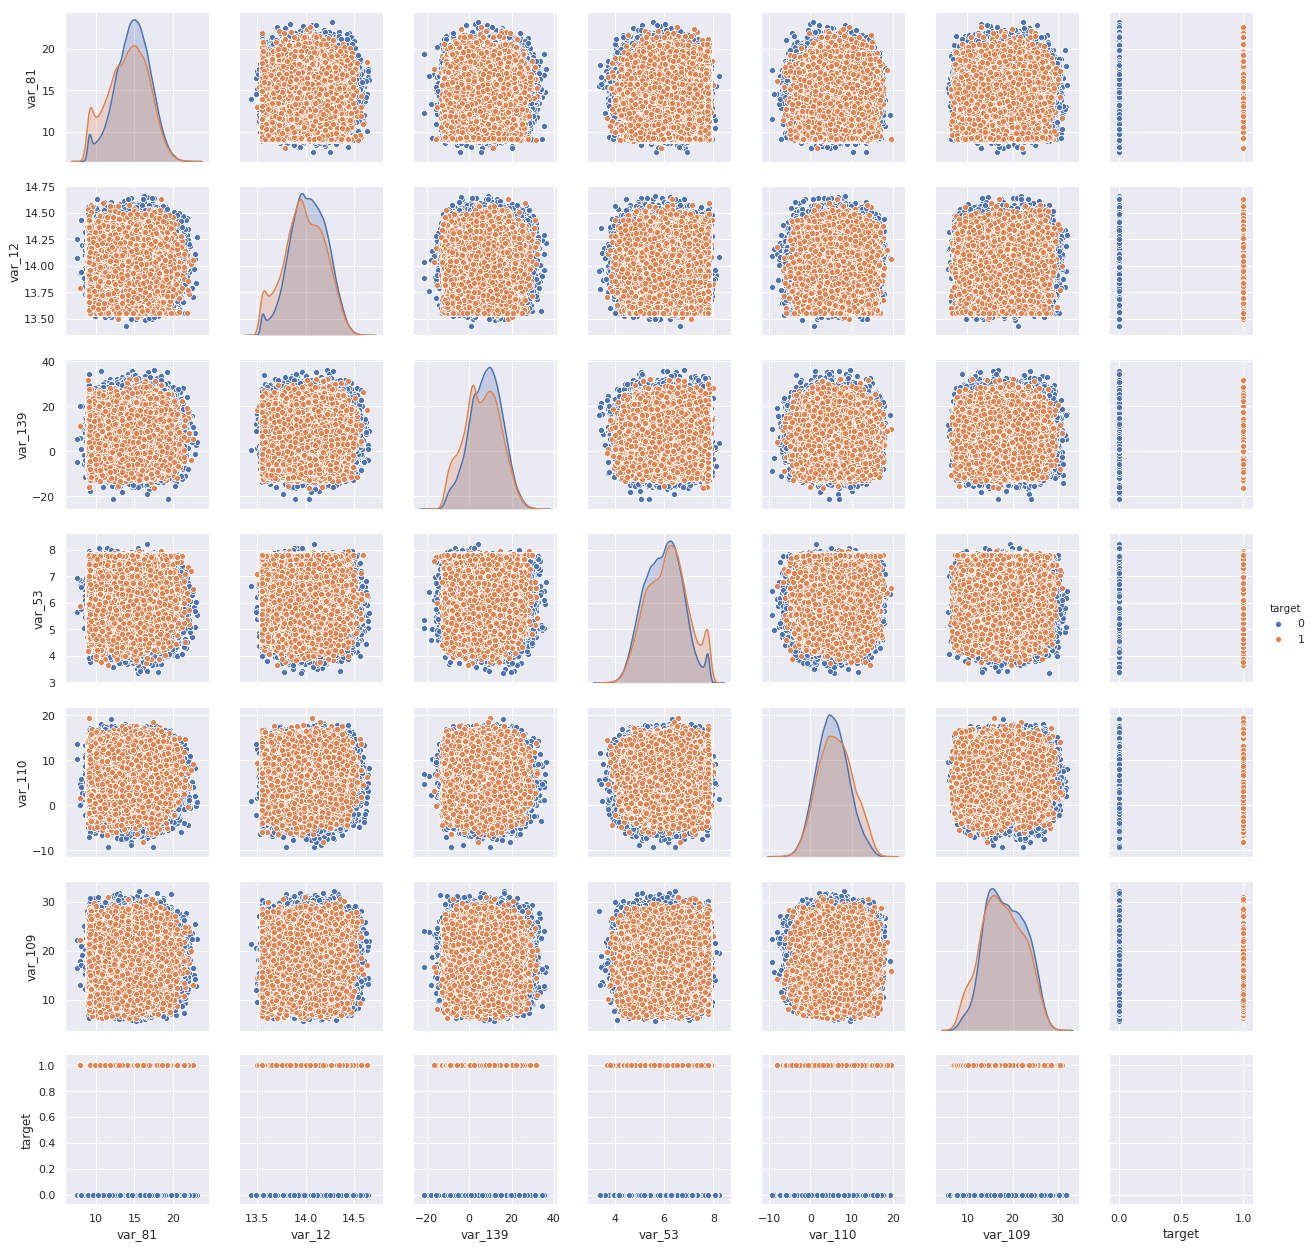

In [157]:
top = top.join(train.target)
sns.pairplot(top, hue = 'target')

var81변수를 살펴보면, 값이 10일때 선을 그어놓은 것처럼 잘 침범하지 않은 것을 알 수 있다. var12도 13.5에서 그렇다. 신기하다!

# Baseline Submissions

In [158]:
y_proba = grid.predict_proba(test.values)
y_proba_train = grid.predict_proba(train.drop('target', axis = 1).values)

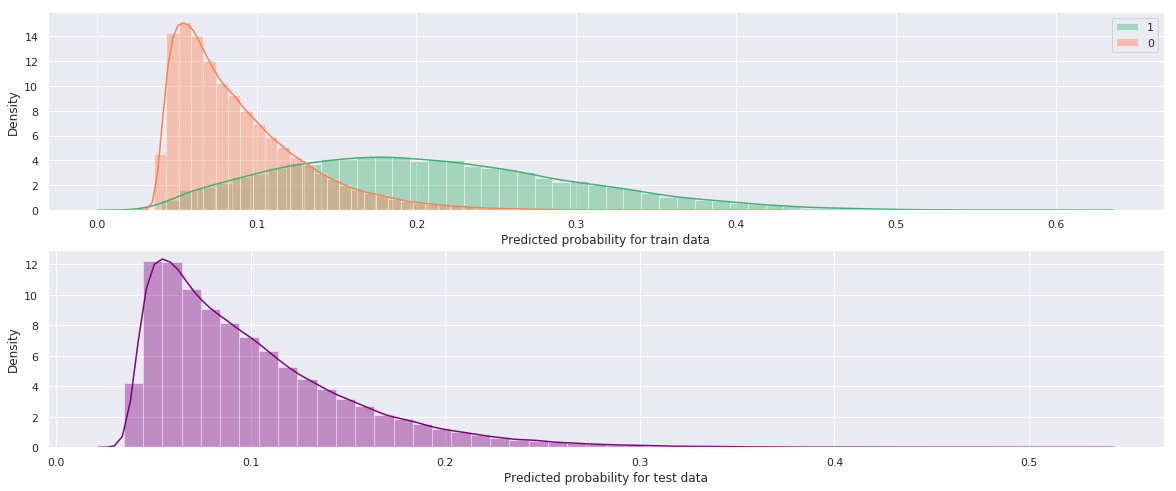

In [159]:
fig, ax = plt.subplots(2,1, figsize = (20,8))

#train data
sns.distplot(y_proba_train[train.target == 1,1], norm_hist=True, color = 'mediumseagreen', ax = ax[0], label = '1')
sns.distplot(y_proba_train[train.target == 0,1], norm_hist=True, color = 'coral', ax = ax[0], label = '0')

#test data
sns.distplot(y_proba[:,1], norm_hist=True, ax = ax[1], color = 'purple')

ax[1].set_xlabel("Predicted probability for test data");
ax[1].set_ylabel("Density");
ax[0].set_xlabel("Predicted probability for train data");
ax[0].set_ylabel("Density");
ax[0].legend();
plt.show()

In [160]:
submission['target'] = y_proba
submission.to_csv('submission_baseline_rf.csv', index = False)

# Feature Engineering

In [161]:
original_features = train.drop(['target','Id'], axis = 1).columns.values

## Rounding & Quantile based binning

In [162]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
import warnings
warnings.filterwarnings('ignore')

In [163]:
for your_feauture in top.drop('target', axis = 1).columns.values :
    train[your_feauture + '_qbinned'] = pd.qcut(train.loc[:,your_feauture].values, q = 10, labels = False) #10등분하여 등급화
    train[your_feauture + '_qbinned'] = encoder.fit_transform(train[your_feauture + '_qbinned'].values.reshape(-1,1))
    
    train[your_feauture + '_rounded'] = np.round(train.loc[:, your_feauture].values)
    train[your_feauture + '_rounded_10'] = np.round(10*train.loc[:, your_feauture].values)
    train[your_feauture + '_rounded_100'] = np.round(100*train.loc[:, your_feauture].values)

## new features importance

In [164]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits = 3, random_state = 0)
rf = RandomForestClassifier(max_depth = 15, n_estimators = 15, min_samples_leaf = 20, n_jobs = -1)

scores = []
X = train.drop('target', axis = 1).values
y  = train.target.values

for tr_idx, val_idx in cv.split(X,y) :
    
    X_train, y_train = X[tr_idx], y[tr_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    
    rf.fit(X_train, y_train)
    y_proba = rf.predict_proba(X_val)
    y_pred = np.zeros(y_proba.shape[0])
    y_pred[y_proba[:,1] >= 0.166] = 1 #0.166라는 값이 어디 서 왔을까?ㅎ 위의 분포를 보면 대강 유추할 수 있긴 하지만 궁금 ㅎㅎ
    
    score = roc_auc_score(y_val, y_pred)
    print(score)
    scores.append(score)
    
print(np.round(np.mean(scores),4))
print(np.round(np.std(scores),4))

0.6506710245464248
0.6515073400834707
0.5077754961078721
0.6033
0.0676


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

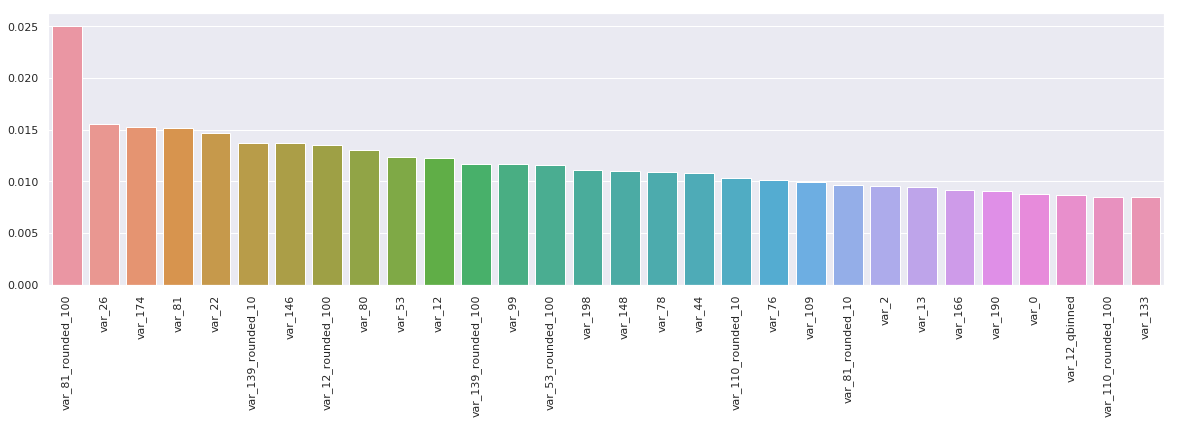

In [165]:
importances = rf.feature_importances_
feature_names = train.drop('target', axis = 1).columns.values
idx = np.argsort(importances)[::-1][:30]

plt.figure(figsize=(20,5))
sns.barplot(x = feature_names[idx], y = importances[idx])
plt.xticks(rotation = 90)

# Gaussian Mixture Clustering
데이터의 대부분이 큰 가우시안 분포처럼 생겼다. 게다가 중요변수를 뽑을 수 있는 적어도 하나 혹은 두 개의 가우시안이 있다.

In [166]:
col1 = 'var_81'
col2 = 'var_12'

N = 70000

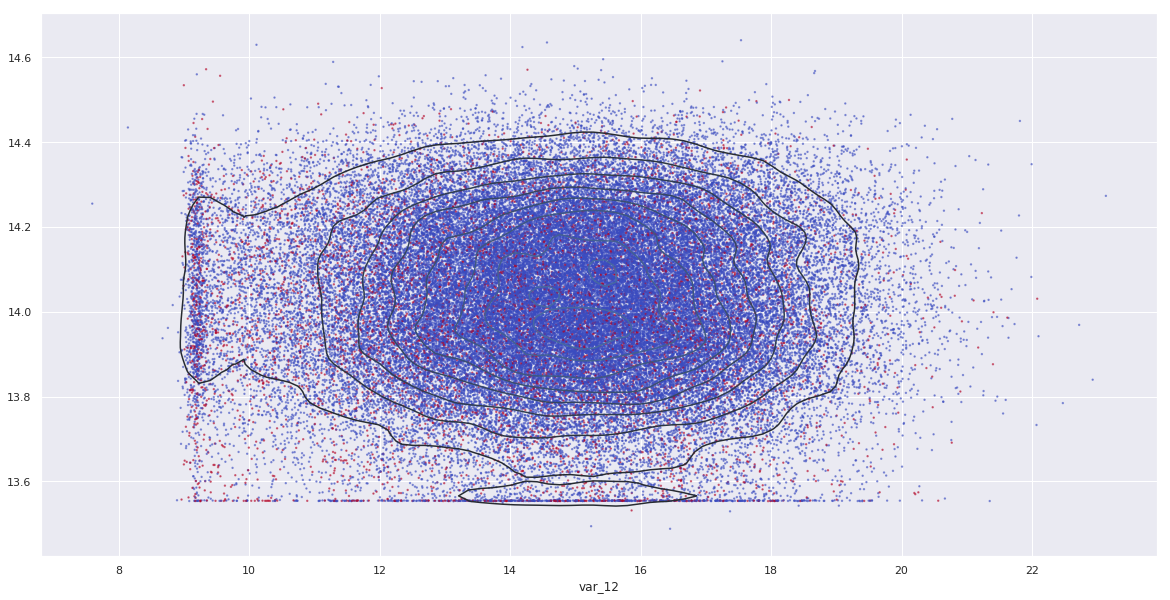

In [167]:
fig, ax = plt.subplots(1,1, figsize = (20,10))
sns.kdeplot(train[col1].values[:N], train[col2].values[:N])

ax.scatter(train[col1].values[0:N], train[col2].values[0:N],
           s=2, c=train.target.values[0:N], cmap="coolwarm", alpha=0.5)
ax.set_xlabel(col1)
ax.set_xlabel(col2);

- 하나의 큰 가우시안분포와 작은 가우시안 분포 존재!
- 여기서도 위에서 본 것처럼 sharp line을 발견할 수 있는 것이 흥미롭다
- 클러스터링 해보자

In [168]:
combined = train.drop(['target', 'Id'], axis = 1).append(test.drop('Id', axis = 1))
combined.shape

(400000, 224)

In [169]:
max_components = 10
start_components = 3
n_splits = 3
K = len(train)

X = train.loc[:, original_features].values[:K]
y = train.target.values[:K]

In [170]:
seeds = np.random.RandomState(0).randint(0,100, size = (max_components - start_components))
seeds

array([44, 47, 64, 67, 67,  9, 83])

In [171]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

X_scaled = scaler.fit_transform(X)

In [176]:
fit_gaussians = False

In [177]:
if fit_gaussians :
    components = np.arange(start_components, max_components, 1)
    kf = StratifiedKFold(random_state=0, n_splits=n_splits)
    
    scores = np.zeros(shape = (max_components - start_components, n_splits))
    
    for m in components :
        split = 0
        print('Components : ' + str(m))
        for tr_idx, val_idx in kf.split(X_scaled, y) :
            print('Split ' + str(split))
            X_train, X_test = X_scaled[tr_idx], X_scaled[val_idx]
            gm = GaussianMixture(n_components = m, random_state = seeds[m-start_components])
            gm.fit(X_train)
            score = gm.score(x_test)
            score[m-start_components] = score
            split+=1
            
    print(np.round(np.mean(scores, axis = 1), 2))
    print(np.round(np.std(scores, axis = 1), 2))
    
else :
    best_seed = seeds[0]
    best_component = 3

In [178]:
X = train.loc[:, original_features].values

gm = GaussianMixture(n_components=best_component, random_state=best_seed)
X_scaled = scaler.transform(X)
gm.fit(X_scaled)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=44, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [180]:
train['cluster'] = gm.predict(X_scaled)
train['logL'] = gm.score_samples(X_scaled) #Compute the weighted log probabilities for each sample.

test['cluster'] = gm.predict(test.loc[:, original_features].values)
test['logL'] = gm.score_samples(test.loc[:, original_features].values)

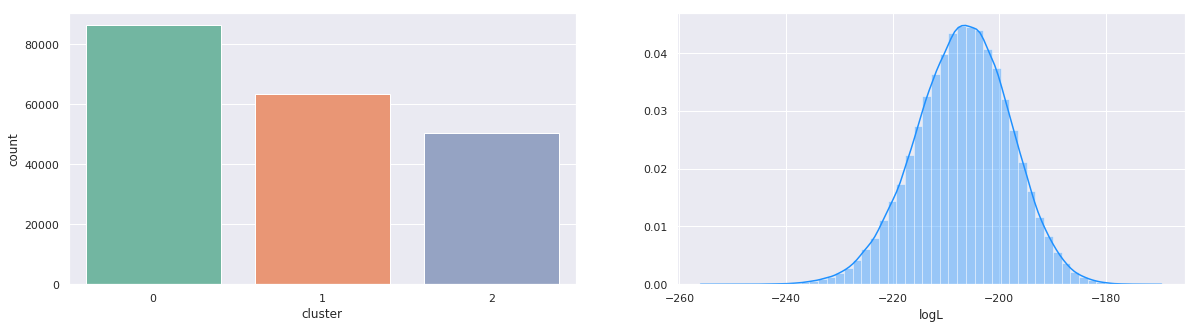

In [183]:
fig, ax = plt.subplots(1,2, figsize = (20,5))
sns.countplot(train.cluster, palette = 'Set2', ax = ax[0])
sns.distplot(train.logL, color="Dodgerblue", ax=ax[1])

In [189]:
cluster_occupation = train.groupby('cluster').target.value_counts() / train.groupby('cluster').size()*100
cluster_occupation = cluster_occupation.loc[:,1]
cluster_occupation

cluster
0     3.728279
1    18.552686
2    10.160778
dtype: float64

In [191]:
target_occupation = train.groupby('target').cluster.value_counts() / train.groupby('target').size()*100
target_occupation = target_occupation.loc[1,:]
target_occupation.index = target_occupation.index.droplevel('target')
target_occupation

cluster
1    58.538163
2    25.470196
0    15.991641
dtype: float64

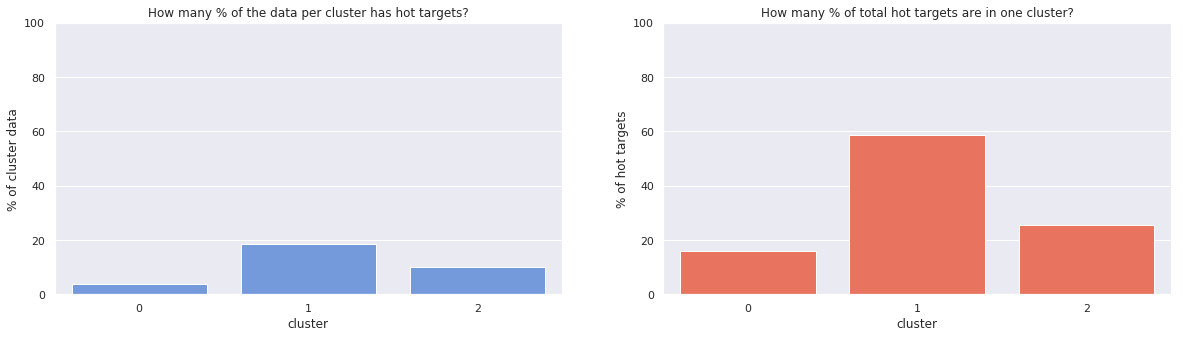

In [192]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].set_title("How many % of the data per cluster has hot targets?")
sns.barplot(cluster_occupation.index, cluster_occupation.values, ax=ax[0], color="cornflowerblue")
ax[0].set_ylabel("% of cluster data")
ax[0].set_ylim([0,100])

ax[1].set_title("How many % of total hot targets are in one cluster?")
sns.barplot(target_occupation.index, target_occupation.values, ax=ax[1], color="tomato")
ax[1].set_ylabel("% of hot targets")
ax[1].set_ylim([0,100]);

Text(0.5, 0, 'Feature')

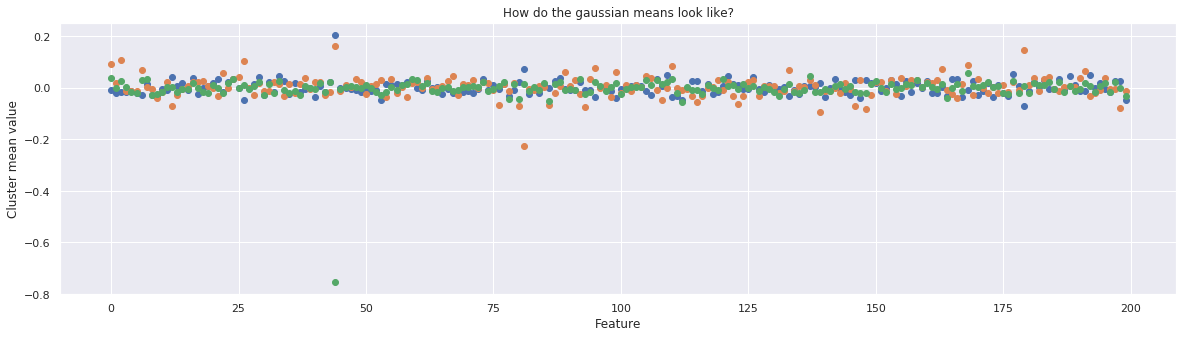

In [193]:
plt.figure(figsize=(20,5))
for n in range(gm.means_.shape[0]):
    plt.plot(gm.means_[n,:], 'o')
plt.title("How do the gaussian means look like?")
plt.ylabel("Cluster mean value")
plt.xlabel("Feature")

어렵다 ㅜㅜ
Gaussain Mixture그래서 왜 쓴 거야ㅜㅜ